In [83]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Running the nway function for distance-based catalogue matching, using eROSITA as the primary catalogue and sdss as the secondary catalogue:

In [ ]:
%run /Users/bobbyscott/.local/bin/nway.py ./data/eFEDS_AGN_spec_V17.6.fits 10 ./data/DR16Q_v4.fits 1.2 --out=./data/matched.fits --radius 70

In [41]:
%run /Users/bobbyscott/.local/bin/nway.py ./data/eFEDS_AGN_spec_V17.6.fits 10 ./data/DR16Q_v4.fits 1.2 --out=./data/matched_check.fits --radius 150

NWAY arguments:
    catalogues:  ./data/eFEDS_AGN_spec_V17.6.fits, ./data/DR16Q_v4.fits
    position errors/columns:  10, 1.2
      from catalogue "AGN" (22079), density gives 6.41e+06 on entire sky
      from catalogue "CATALOG" (750414), density gives 4.13e+06 on entire sky
    magnitude columns:  



matching with 150.000000 arcsec radius
matching: 16568390706 naive possibilities
matching: hashing
    using RA  columns: RA_CORR, RA
    using DEC columns: DEC_CORR, DEC
merging in 249 columns from input catalogues ...
100%|██████████| 249/249 [00:04<00:00, 59.62it/s] 
    adding angular separation columns
matching:  28010 matches after filtering by search radius

 15%|█▌        | 3375/22079 [00:00<00:00, 33743.60it/s]

Computing distance-based probabilities ...
  finding position error columns ...
    Position error for "AGN": using fixed value 10.000000
    Position error for "CATALOG": using fixed value 1.200000
  finding position columns ...
  building primary_id index ...
  computing probabilities ...
      correcting for unrelated associations ... not necessary

Computing final probabilities ...
    grouping by column "AGN_ID_SRC" and flagging ...


100%|██████████| 22079/22079 [00:00<00:00, 35801.16it/s]




  You can calibrate a p_any cut-off with the following steps:
   1) Create a offset catalogue to simulate random sky positions:
      nway-create-fake-catalogue.py --radius 300 ./data/eFEDS_AGN_spec_V17.6.fits ./data/eFEDS_AGN_spec_V17.6-fake.fits
   2) Match the offset catalogue in the same way as this run:
      /Users/bobbyscott/.local/bin/nway.py ./data/eFEDS_AGN_spec_V17.6-fake.fits 10 ./data/DR16Q_v4.fits 1.2 --out=./data/matched_check.fits-fake.fits --radius 150
   3) determining the p_any cutoff that corresponds to a false-detection rate
      nway-calibrate-cutoff.py ./data/matched_check.fits ./data/matched_check.fits-fake.fits


creating output FITS file ...
    writing "./data/matched_check.fits" (28010 rows, 256 columns) ...


We plot the number of mathches for matching radii ranging from 20-150, we see that from roughly 70" onwards, the number of matches shows an exponential increase, so we choose a matching radius of 70".

In [84]:
numbers = np.array([20,30,40,50,60,70,80,90,100,110,120,130,140,150])
matches = np.array([24413, 24479, 24566, 24698, 24892, 25116, 25350, 25632, 25942, 26287, 26666, 27064, 27527, 28010])
matches = matches-22079
log_matches = np.log(matches)

In [97]:
def func(x, a, b):
    return a*x + b
popt, pcov = curve_fit(func, numbers[5:], log_matches[5:], p0=[1,1])
x = np.linspace(20,150, 1000)
fit = func(x, *popt)

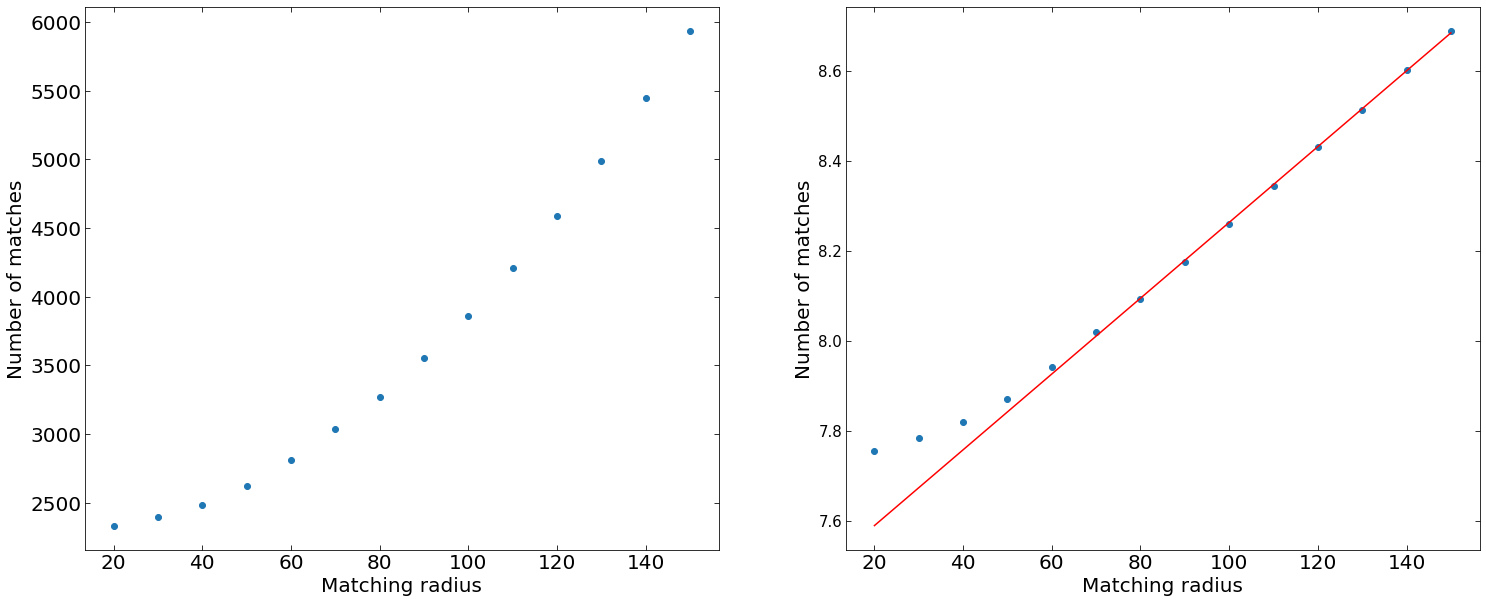

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(25,10))
ax = axes[0]
ax.scatter(numbers, matches)
ax.tick_params(axis='both', direction = 'in', labelsize=20, length=5)
ax.tick_params(top=True, bottom=True, left=True, right=True)
ax.set_xlabel('Matching radius', fontsize=20)
ax.set_ylabel('Number of matches', fontsize=20)
ax = axes[1]
ax.scatter(numbers, log_matches)
ax.plot(x, fit, color='red')
ax.tick_params(axis='both', which = 'both', direction = 'in',labelsize=20, length=5)
ax.tick_params(top=True, bottom=True, left=True, right=True)
ax.set_xlabel('Matching radius', fontsize=20)
ax.set_ylabel('Number of matches', fontsize=20)

plt.setp(ax.get_yticklabels(), fontsize=15)
plt.show()

In [8]:
with fits.open('./data/matched.fits') as hdul:
    agn_ra = list(hdul[1].data['AGN_RA_CORR'])
    agn_dec = list(hdul[1].data['AGN_DEC_CORR'])
    catalog_ra = list(hdul[1].data['CATALOG_RA'])
    catalog_dec = list(hdul[1].data['CATALOG_DEC'])
    p_any = list(hdul[1].data['p_any'])
    catalog_plate = list(hdul[1].data['CATALOG_PLATE'])
    catalog_mjd = list(hdul[1].data['CATALOG_MJD'])
    catalog_fiberid = list(hdul[1].data['CATALOG_FIBERID'])
    eFEDS_redshift = np.round(list(hdul[1].data['AGN_CTP_REDSHIFT']),6)
    sdss_redshift = np.round(list(hdul[1].data['CATALOG_Z_VI']),6)
    ctp_id = list(hdul[1].data['AGN_CTP_LS8_UNIQUE_OBJID'])
    agn_id = list(hdul[1].data['AGN_ID_SRC'])
    sdss_id = list(hdul[1].data['CATALOG_OBJID'])
    match_flag = list(hdul[1].data['match_flag'])
    inarea90 = list(hdul[1].data['AGN_inArea90'])
    agn_ctp_quality = list(hdul[1].data['AGN_CTP_quality'])
    det_like = list(hdul[1].data['AGN_DET_LIKE'])
    ctp_redshift_grade = list(hdul[1].data['AGN_CTP_REDSHIFT_GRADE'])
    best_redshift = np.round(list(hdul[1].data['CATALOG_Z']),6)
    n_h = list(hdul[1].data['AGN_lognH_Med_m1'])
    soft_lum = list(hdul[1].data['AGN_LumiIntr_Med_s'])
    

In [16]:
match_df = pd.DataFrame({'SDSS_ID': sdss_id,'agn_id':agn_id, 'eFEDS_REDSHIFT': eFEDS_redshift,
                         'best_REDSHIFT': best_redshift, 'CATALOG_RA': catalog_ra,
                         'CATALOG_DEC': catalog_dec, 'p_any': p_any, 'CATALOG_PLATE':catalog_plate,
                         'CATALOG_MJD': catalog_mjd, 'CATALOG_FIBERID': catalog_fiberid,
                         'match_flag': match_flag, 'inarea90':inarea90, 'ctp_quality': agn_ctp_quality,
                         'det_like':det_like, 'ctp_redshift_grade': ctp_redshift_grade, 'N_H': n_h,
                         'SOFT_LUMINOSITY': soft_lum})
match_df.drop(match_df[match_df['CATALOG_PLATE']==-99].index, inplace=True)

(array([2.2079e+04, 1.0130e+03, 2.2500e+02, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.2270e+03, 0.0000e+00, 5.7000e+02]),
 array([ -99. ,  401.2,  901.4, 1401.6, 1901.8, 2402. , 2902.2, 3402.4,
        3902.6, 4402.8, 4903. ]),
 <BarContainer object of 10 artists>)

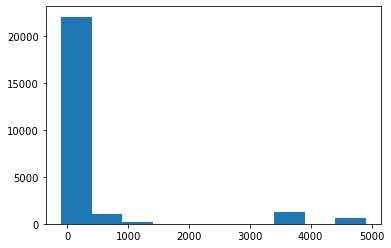

In [21]:
plt.hist(catalog_plate)

In [17]:
match_df

,SDSS_ID,agn_id,eFEDS_REDSHIFT,best_REDSHIFT,CATALOG_RA,CATALOG_DEC,p_any,CATALOG_PLATE,CATALOG_MJD,CATALOG_FIBERID,match_flag,inarea90,ctp_quality,det_like,ctp_redshift_grade,N_H,SOFT_LUMINOSITY
4,1237650795143233717,7,0.322346,0.322247,139.259950,-0.738209,9.949045e-01,472,51955,50,1,True,4,9961.442383,5,19.731468,44.635399
6,1237658423544447024,8,2.871900,0.301766,138.507332,5.130723,7.621726e-07,1193,52652,153,1,True,4,203.909912,3,20.613472,45.996899
8,1237658423544447024,9,0.301340,0.301766,138.507332,5.130723,9.950856e-01,1193,52652,153,1,True,4,9294.518555,5,19.821041,44.713902
11,1237654601554985045,11,0.512114,0.512223,130.762376,3.038584,9.950967e-01,564,52224,471,1,True,4,7421.844727,5,19.869638,45.120800
19,1237673709868417096,24,1.024224,1.024000,137.292037,1.359892,9.949766e-01,3819,55540,186,1,True,4,3807.828613,5,20.132584,45.508400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25029,1237654605317669312,32302,2.472200,2.337000,141.614646,3.534769,9.669534e-01,4735,55651,918,1,True,2,6.884191,4,21.774380,43.139900
25032,1237658492793913717,32306,2.338644,2.338000,128.655375,5.777166,9.926254e-01,4764,55646,927,1,False,4,6.629631,5,21.241119,44.858501
25074,1237658300595044784,32488,0.379500,1.947841,129.292031,5.133709,6.798891e-01,1187,52708,230,1,True,4,6.138684,4,21.976753,42.148800
25088,1237650795674993112,32533,2.073045,2.070000,127.609678,-0.403802,9.945859e-01,4791,55889,216,1,True,4,7.232318,5,21.154482,44.336300


Creating dataframe of matched AGN with important columns, dropping the original first catalogue from the final dataframe and selecting AGN that have highly probable counterpart match success (p_any):

In [4]:
hdul = fits.open('./data/matched.fits')


data = hdul[1].data



filtered_matched_sources = data[data['CATALOG_PLATE'] !=-99]



filtered_hdu = fits.BinTableHDU(data=filtered_matched_sources, header=hdul[1].header)

filtered_hdu.writeto('./data/filtered_matched.fits', overwrite=True)

hdul.close()

In [5]:
%run /Users/bobbyscott/.local/bin/nway-create-fake-catalogue.py --radius 100 ./data/eFEDS_AGN_spec_V17.6.fits ./data/eFEDS_AGN_spec_V17.6-fake.fits

  0%|          | 0/22079 [00:00<?, ?it/s]

opening ./data/eFEDS_AGN_spec_V17.6.fits
    using RA  column: RA_CORR
    using DEC column: DEC_CORR
finding good pixelation...
  nside=16: the 400 test objects have a total of 704879 neighbors
  nside=32: the 400 test objects have a total of 201366 neighbors
  nside=64: the 400 test objects have a total of 53782 neighbors
  nside=128: the 400 test objects have a total of 14100 neighbors
  nside=256: the 400 test objects have a total of 3879 neighbors
    accepting.


100%|██████████| 22079/22079 [00:54<00:00, 404.42it/s]

writing "./data/eFEDS_AGN_spec_V17.6-fake.fits" (22079 rows)


In [6]:
%run /Users/bobbyscott/.local/bin/nway.py ./data/eFEDS_AGN_spec_V17.6-fake.fits 10 ./data/DR16Q_v4.fits 0.5 --out=./data/matched.fits-fake.fits --radius 50

NWAY arguments:
    catalogues:  ./data/eFEDS_AGN_spec_V17.6-fake.fits, ./data/DR16Q_v4.fits
    position errors/columns:  10, 0.5
      from catalogue "AGN" (22079), density gives 6.41e+06 on entire sky
      from catalogue "CATALOG" (750414), density gives 4.13e+06 on entire sky
    magnitude columns:  



matching with 50.000000 arcsec radius
matching: 16568390706 naive possibilities
matching: hashing
    using RA  columns: RA_CORR, RA
    using DEC columns: DEC_CORR, DEC
matching: healpix hashing on pixel resolution ~ 72.145215 arcsec (nside=2048)
100%|██████████| 772493/772493 [00:11<00:00, 69300.44it/s] 
matching: collecting from 122026 buckets, creating cartesian products ...
100%|██████████| 122026/122026 [00:00<00:00, 693602.50it/s]
matching:  37757 unique matches from cartesian product. sorting ...
/Users/bobbyscott/.local/lib/python3.8/site-packages/nwaylib/fastskymatch.py:246: UserWarning: Persisting input arguments took 9.66s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  resultsta

Computing distance-based probabilities ...
  finding position error columns ...
    Position error for "AGN": using fixed value 10.000000
    Position error for "CATALOG": using fixed value 0.500000
  finding position columns ...
  building primary_id index ...
  computing probabilities ...
      correcting for unrelated associations ... not necessary

Computing final probabilities ...
    grouping by column "AGN_ID_SRC" and flagging ...


100%|██████████| 22079/22079 [00:00<00:00, 37993.62it/s]




  You can calibrate a p_any cut-off with the following steps:
   1) Create a offset catalogue to simulate random sky positions:
      nway-create-fake-catalogue.py --radius 100 ./data/eFEDS_AGN_spec_V17.6-fake.fits ./data/eFEDS_AGN_spec_V17.6-fake-fake.fits
   2) Match the offset catalogue in the same way as this run:
      /Users/bobbyscott/.local/bin/nway.py ./data/eFEDS_AGN_spec_V17.6-fake-fake.fits 10 ./data/DR16Q_v4.fits 0.5 --out=./data/matched.fits-fake.fits-fake.fits --radius 50
   3) determining the p_any cutoff that corresponds to a false-detection rate
      nway-calibrate-cutoff.py ./data/matched.fits-fake.fits ./data/matched.fits-fake.fits-fake.fits


creating output FITS file ...
    writing "./data/matched.fits-fake.fits" (22262 rows, 256 columns) ...


Exception ignored in: <function FITS_rec.__del__ at 0x7fa40824e1f0>
Traceback (most recent call last):
  File "/Users/bobbyscott/opt/anaconda3/lib/python3.8/site-packages/astropy/io/fits/fitsrec.py", line 636, in __del__
    col.array = col.array.copy()
KeyboardInterrupt: 


In [7]:
hdul = fits.open('./data/matched.fits-fake.fits')


data = hdul[1].data


filtered_matched_sources = data[data['CATALOG_PLATE'] !=-99]

filtered_hdu = fits.BinTableHDU(data=filtered_matched_sources, header=hdul[1].header)

filtered_hdu.writeto('./data/filtered_matched.fits-fake.fits', overwrite=True)

hdul.close()

In [8]:
%run /Users/bobbyscott/.local/bin/nway-calibrate-cutoff.py ./data/filtered_matched.fits ./data/filtered_matched.fits-fake.fits

/Users/bobbyscott/.local/bin/nway-calibrate-cutoff.py:54: RuntimeWarning: Mean of empty slice.
  efficiency = [(p_any0 > cutoff).mean() for cutoff in cutoffs]
/Users/bobbyscott/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bobbyscott/.local/bin/nway-calibrate-cutoff.py:55: RuntimeWarning: Mean of empty slice.
  error_rate = [(p_any0_offset > cutoff).mean() for cutoff in cutoffs]


created plot "./data/filtered_matched.fits_p_any_cutoffquality.pdf"
created plot "./data/filtered_matched.fits_p_any_p_i.pdf"

A false detection rate of <1% is not possible.

A false detection rate of <3% is not possible.

A false detection rate of <5% is not possible.

A false detection rate of <10% is not possible.
